# stepAIC - Stepwise linear regression to minimimize AIC

Example of stepwise linear regression to minimize AIC and eliminate non-signficant predictors. 

In this example we will use the mtcars dataset from the R MASS package

In [1]:
# # Run the following commands to install PyOAE and delta_method for the first time
# !pip install git+https://github.com/gjpelletier/stepAIC.git

# # Run the following commands to upgrade PyOAE and delta_method to the latest versions
# !pip install git+https://github.com/gjpelletier/stepAIC.git --upgrade

In [2]:
from stepAIC import stepAIC
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# import the dataset
df = pd.read_csv("mtcars.csv")
print(df.head())

            rownames   mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
0          Mazda RX4  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
1      Mazda RX4 Wag  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
2         Datsun 710  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
3     Hornet 4 Drive  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
4  Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

   carb  
0     4  
1     4  
2     1  
3     1  
4     2  


In this example we will use stepAIC to find the optimum set of predictor variables using mpg as the response variable. The full set of candidate predictor variables will include cyl, disp, hp, drat, wt, qsec, vs, am, gear, and carb.

In [4]:
# Selecting specific columns to use for this example
df = df[['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,32.0,20.090625,6.026948,10.400,15.42500,19.200,22.80,33.900
cyl,32.0,6.187500,1.785922,4.000,4.00000,6.000,8.00,8.000
disp,32.0,230.721875,123.938694,71.100,120.82500,196.300,326.00,472.000
hp,32.0,146.687500,68.562868,52.000,96.50000,123.000,180.00,335.000
drat,32.0,3.596563,0.534679,2.760,3.08000,3.695,3.92,4.930
wt,32.0,3.217250,0.978457,1.513,2.58125,3.325,3.61,5.424
qsec,32.0,17.848750,1.786943,14.500,16.89250,17.710,18.90,22.900
vs,32.0,0.437500,0.504016,0.000,0.00000,0.000,1.00,1.000
am,32.0,0.406250,0.498991,0.000,0.00000,0.000,1.00,1.000
gear,32.0,3.687500,0.737804,3.000,3.00000,4.000,4.00,5.000


In [5]:
# report the shape of the dataset
print("There are {0} rows and {1} columns in the dataset".format(df.shape[0],df.shape[1]))

There are 32 rows and 11 columns in the dataset


In [6]:
# # check duplicated rows
print("There are {} duplicated rows in the dataset".format(df.duplicated().sum()))

There are 0 duplicated rows in the dataset


In [7]:
# drop duplicates and missing values and print the shape again
df.drop_duplicates(inplace=True)
print("There are {0} rows and {1} columns in the dataset after removing the duplicated rows"
      .format(df.shape[0],df.shape[1]))

There are 32 rows and 11 columns in the dataset after removing the duplicated rows


In [8]:
# clean the data by dropping rows with nan
df = df.dropna()
print("There are {0} rows and {1} columns in the dataset after removing the rows with nan values"
      .format(df.shape[0],df.shape[1]))

# # optional - fill missing data with mean or median
# # df['column_name'].fillna(df['column_name'].mean(), inplace=True)
# for column in df.columns:
#     df[column].fillna(df[column].mean(), inplace=True)

There are 32 rows and 11 columns in the dataset after removing the rows with nan values


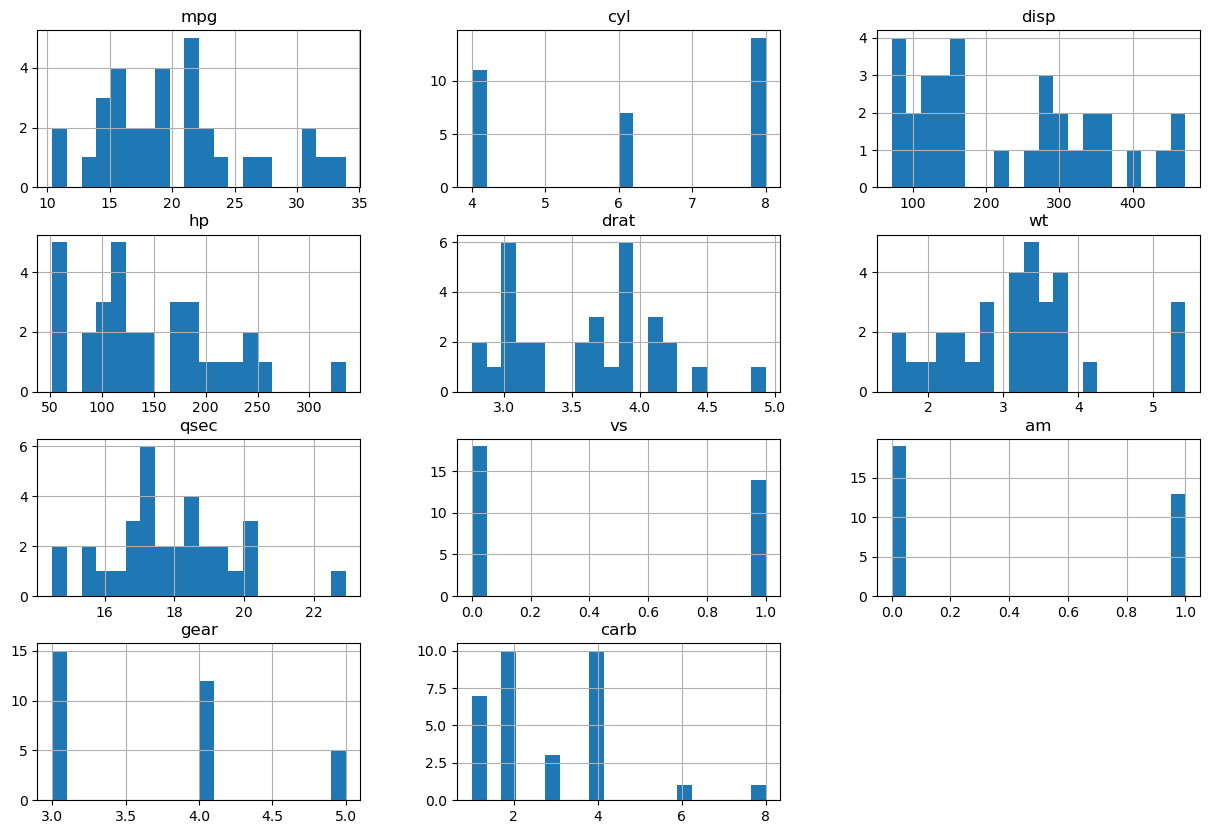

In [9]:
# show histrograms of the data
df.hist(bins=20, figsize=(15, 10));

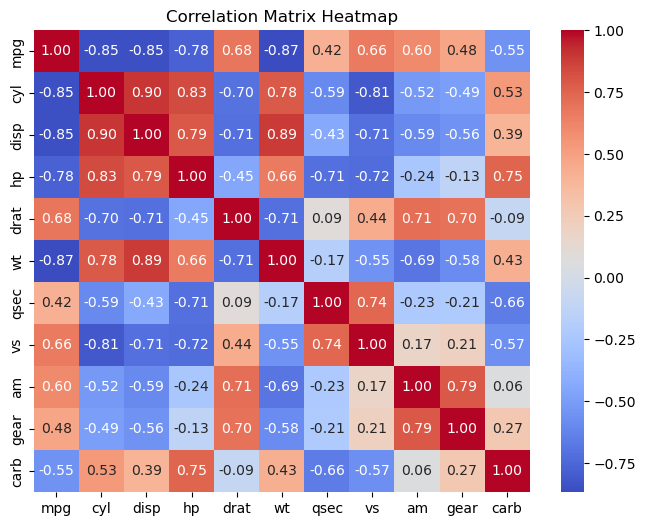

In [10]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [11]:
# Show which variables are potentially the most correlated predictors of strength
print('The following variables are potentially the most influential \n based on having absolute values of correlation coefficients >= 0.2:')
correlation_matrix['mpg'][abs(correlation_matrix['mpg'])>=.2]

The following variables are potentially the most influential 
 based on having absolute values of correlation coefficients >= 0.2:


mpg     1.000000
cyl    -0.852162
disp   -0.847551
hp     -0.776168
drat    0.681172
wt     -0.867659
qsec    0.418684
vs      0.664039
am      0.599832
gear    0.480285
carb   -0.550925
Name: mpg, dtype: float64

In [12]:
# Split the dataset into independent (X) and dependent (y) variables
X = df.drop(['mpg'], axis = 1)
y = df['mpg']

In [13]:
# Variance Inflation Factors of all possible predictor variables
# VIF>5 indicates unacceptable collinearity
# Try dropping predictors that are most correlated with other predictors
# until all VIF values of the predictors are < 5

# import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X.copy()
# X_vif = X_vif[['mpg', 'qsec']]

# Add a constant for the intercept term
X_vif = sm.add_constant(X_vif)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns

vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                    for i in range(len(X_vif.columns))]

# print('VIF: \n',vif_data)
print('VIF of independent variables included in the final model:')
print('VIF<5 indicates acceptable collinearity')
vif_data

VIF of independent variables included in the final model:
VIF<5 indicates acceptable collinearity


,Feature,VIF
0,const,1596.273030
1,cyl,15.373833
2,disp,21.620241
3,hp,9.832037
4,drat,3.374620
5,wt,15.164887
6,qsec,7.527958
7,vs,4.965873
8,am,4.648487
9,gear,5.357452


Most of the VIF values are greater than 5, which indicates excessive multi-collinearity between predictors. We will check the VIF values of the final selected predictors to check if the final predictors still have excessive collinearity.

# Try stepAIC using 70% of the data for training

In [14]:
# Split the dataset into training and test subsets with test size of 30% and a random state of 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state = 1)
# report the shape
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (22,10)
y_train shape : (22,)
X_test shape : (10,10)
y_test shape : (10,)


In [15]:
# run the stepAIC procedure to find the best model that minimizes AIC and eliminates non-signficant features
best_features, best_model = stepAIC(X_train, y_train)
print('\nBEST MODEL RETURNED')
print("Best features returned: ", best_features,'\n')
print(best_model.summary())


FORWARD STEP 1 , AIC= 98.68
Features added:  ['wt'] 

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     53.83
Date:                Sat, 03 May 2025   Prob (F-statistic):           4.32e-07
Time:                        21:05:09   Log-Likelihood:                -47.340
No. Observations:                  22   AIC:                             98.68
Df Residuals:                      20   BIC:                             100.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [16]:
# Variance Inflation Factors of final selected predictor variables
# VIF>5 indicates unacceptable collinearity
# Try dropping predictors that are most correlated with other predictors
# until all VIF values of the predictors are < 5

# import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X[['wt', 'gear', 'carb']]

# Add a constant for the intercept term
X_vif = sm.add_constant(X_vif)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns

vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                    for i in range(len(X_vif.columns))]

# print('VIF: \n',vif_data)
print('VIF of independent variables included in the final model:')
print('VIF<5 indicates acceptable collinearity')
vif_data

VIF of independent variables included in the final model:
VIF<5 indicates acceptable collinearity


,Feature,VIF
0,const,155.183047
1,wt,3.488856
2,gear,3.082472
3,carb,2.488814


The final selected predictor variables all have VIF<5 which indicates acceptable multi-collinearity

In [17]:
# Use statsmodel OLS to fit the final model to use for residual plotting
# OLS library expects the X and y to be given in one single dataframe
# this is different from the example we saw in lab sessions
import statsmodels.formula.api as smf
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()
lr_result = smf.ols(
    formula = 'mpg ~ wt + gear + carb',
    data = df_train).fit()
print(lr_result.summary()) # Inferential statistics

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     49.46
Date:                Sat, 03 May 2025   Prob (F-statistic):           6.80e-09
Time:                        21:05:48   Log-Likelihood:                -37.245
No. Observations:                  22   AIC:                             82.49
Df Residuals:                      18   BIC:                             86.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.6496      4.076      4.330      0.0

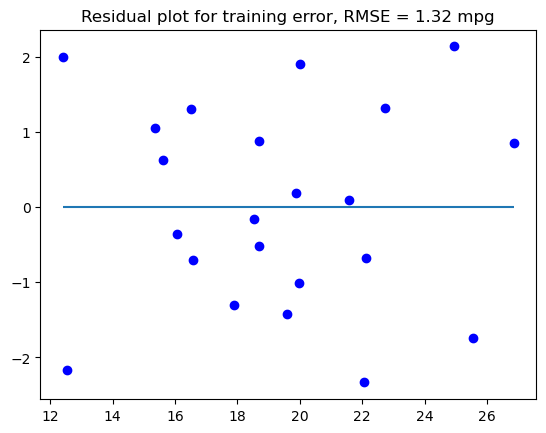

In [18]:
# residual plot for training error
y_pred_train = lr_result.predict(X_train)
res_plot = plt.scatter(y_pred_train, (y_pred_train - y_train), c='b')
rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))
plt.hlines(y=0, xmin=min(y_pred_train), xmax=max(y_pred_train))
plt.title("Residual plot for training error, RMSE = {:.2f} mpg".format(rmse_train))
plt.show()

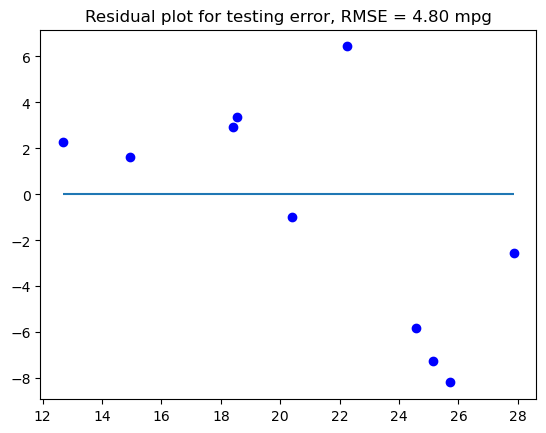

In [19]:
# residual plot for testing error
y_pred_test = lr_result.predict(X_test)
res_plot = plt.scatter(y_pred_test, (y_pred_test - y_test), c='b')
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))
plt.hlines(y=0, xmin=min(y_pred_test), xmax=max(y_pred_test))
plt.title("Residual plot for testing error, RMSE = {:.2f} mpg".format(rmse_test))
plt.show()

# Try stepAIC again using 80% of the data for training

In [20]:
# Split the dataset into training and test subsets with test size of 30% and a random state of 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state = 1)
# report the shape
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (25,10)
y_train shape : (25,)
X_test shape : (7,10)
y_test shape : (7,)


In [21]:
# run the stepAIC procedure to find the best model that minimizes AIC and eliminates non-signficant features
best_features, best_model = stepAIC(X_train, y_train)
print('\nBEST MODEL RETURNED')
print("Best features returned: ", best_features,'\n')
print(best_model.summary())


FORWARD STEP 1 , AIC= 124.15
Features added:  ['wt'] 

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     61.37
Date:                Sat, 03 May 2025   Prob (F-statistic):           6.14e-08
Time:                        21:06:01   Log-Likelihood:                -60.073
No. Observations:                  25   AIC:                             124.1
Df Residuals:                      23   BIC:                             126.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [22]:
# Variance Inflation Factors of final selected predictor variables
# VIF>5 indicates unacceptable collinearity
# Try dropping predictors that are most correlated with other predictors
# until all VIF values of the predictors are < 5

# import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X[['wt', 'hp']]

# Add a constant for the intercept term
X_vif = sm.add_constant(X_vif)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns

vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                    for i in range(len(X_vif.columns))]

# print('VIF: \n',vif_data)
print('VIF of independent variables included in the final model:')
print('VIF<5 indicates acceptable collinearity')
vif_data

VIF of independent variables included in the final model:
VIF<5 indicates acceptable collinearity


,Feature,VIF
0,const,12.161539
1,wt,1.766625
2,hp,1.766625


In [23]:
# Use statsmodel OLS to fit the final model to use for residual plotting
# OLS library expects the X and y to be given in one single dataframe
# this is different from the example we saw in lab sessions
import statsmodels.formula.api as smf
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()
lr_result = smf.ols(
    formula = 'mpg ~ wt + hp',
    data = df_train).fit()
print(lr_result.summary()) # Inferential statistics

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     51.85
Date:                Sat, 03 May 2025   Prob (F-statistic):           4.72e-09
Time:                        21:06:24   Log-Likelihood:                -54.533
No. Observations:                  25   AIC:                             115.1
Df Residuals:                      22   BIC:                             118.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.9339      1.684     20.748      0.0

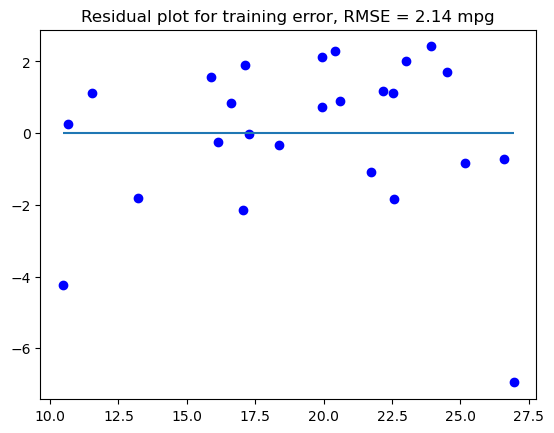

In [24]:
# residual plot for training error
y_pred_train = lr_result.predict(X_train)
res_plot = plt.scatter(y_pred_train, (y_pred_train - y_train), c='b')
rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))
plt.hlines(y=0, xmin=min(y_pred_train), xmax=max(y_pred_train))
plt.title("Residual plot for training error, RMSE = {:.2f} mpg".format(rmse_train))
plt.show()

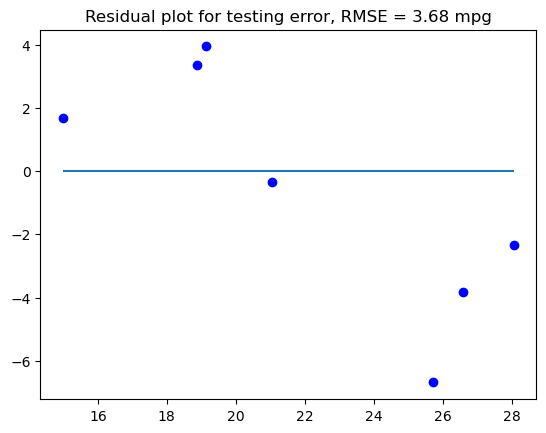

In [25]:
# residual plot for testing error
y_pred_test = lr_result.predict(X_test)
res_plot = plt.scatter(y_pred_test, (y_pred_test - y_test), c='b')
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))
plt.hlines(y=0, xmin=min(y_pred_test), xmax=max(y_pred_test))
plt.title("Residual plot for testing error, RMSE = {:.2f} mpg".format(rmse_test))
plt.show()

The new model has similar RMSE for the training and testing subsets